# Model and Dataset Evaluation

This notebook demonstrates how to load and evaluate a model on a given dataset. It includes:

1. Parameter configuration
2. Data loading (both the dataset and any relevant AnnData objects)
3. Generating embeddings via a model
4. Visualizing embeddings with UMAP
5. Pairwise embedding analysis (e.g., similarity)
6. Metrics computation (e.g., scibEvaluator)
7. Annotation and zero-shot classification

You can adapt the parameters at the top to switch between different models and datasets.

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Imports and Configuration

In [3]:
import anndata
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from mmcontext.engine import OmicsQueryAnnotator
from mmcontext.eval import evaluate_annotation_accuracy, scibEvaluator, zero_shot_classification_roc
from mmcontext.eval.utils import create_emb_pair_dataframe

# mmcontext imports
from mmcontext.file_utils import load_test_adata_from_hf_dataset, setup_logging
from mmcontext.pl import plot_umap, visualize_embedding_clusters
from mmcontext.pl.plotting import plot_embedding_similarity, plot_grouped_bar_chart, plot_query_scores_umap
from mmcontext.utils import consolidate_low_frequency_categories

logger = setup_logging()


############################################
#           CONFIGURABLE PARAMETERS       #
############################################

SAVE_RESULTS = False  # Optionally toggle saving results
SAVE_FIGURES = False  # Optionally toggle saving figures

MODEL_NAME = "jo-mengr/mmcontext-100k-natural_language_annotation-pca-2048-text-unfrozen"  # Example model name
DATASET_NAME = "geo_70k_pairs_natural_language_annotation"  # Example dataset name

# These keys can be adapted to your AnnData
BATCH_KEY = "study"
LABEL_KEY = "natural_language_annotation"  # The column used for bio labels
# Additional keys for scibEvaluator
EMBEDDING_KEYS = [
    "mmcontext_emb",
    "mmcontext_text_emb",
    "text_emb_original",
    "X_geneformer",
    "X_hvg",
    "X_pca",
    "X_scvi",
]

# Zero-shot classification function parameters
ZERO_SHOT_LABEL_KEY = LABEL_KEY
ZERO_SHOT_EMB_KEY = "mmcontext_emb"
ZERO_SHOT_TEXT_TEMPLATE = {}  # "A sample of {} from a healthy individual"

logger.info("Configuration parameters set.")

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))
2025-03-10 14:03:50,869 - root - INFO - Configuration parameters set.


## 2. Data Loading

In [4]:
logger.info("Loading dataset from HuggingFace...")
dataset = load_dataset(f"jo-mengr/{DATASET_NAME}", download_mode="force_redownload")

logger.info("Splitting to test subset...")
test_dataset = dataset["val"]

logger.info("Loading model...")
model = SentenceTransformer(MODEL_NAME)

logger.info("Loading AnnData from dataset...")
adata = load_test_adata_from_hf_dataset(test_dataset)

logger.info("Ensuring batch_key is categorical...")
adata.obs[BATCH_KEY] = adata.obs[BATCH_KEY].astype("category")

logger.info("Data loading complete.")
adata

2025-03-10 14:03:52,996 - root - INFO - Loading dataset from HuggingFace...
Generating val split: 100%|██████████| 14000/14000 [00:00<00:00, 3259701.12 examples/s]
2025-03-10 14:03:56,920 - root - INFO - Splitting to test subset...
2025-03-10 14:03:56,920 - root - INFO - Loading model...
2025-03-10 14:03:56,930 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-03-10 14:03:56,930 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: jo-mengr/mmcontext-100k-natural_language_annotation-pca-2048-text-unfrozen
2025-03-10 14:03:58,407 - mmcontext.pp.MMContextProcessor - INFO - Initialized PrecomputedProcessor. Retrieval mode: numpy. Metadata from AnnData obsm_key: X_pca. 
2025-03-10 14:03:58,775 - root - INFO - Loading AnnData from dataset...
2025-03-10 14:04:45,881 - mmcontext.utils - INFO - File is a valid .h5ad file.
2025-03-10 14:04:52,017 - root - INFO - Ensuring batch_key is categorical...
2025-03-10 14:04:52,023 

AnnData object with n_obs × n_vars = 7000 × 67125
    obs: 'geo_id', 'accession', 'sample_type', 'sample_type_confidence', 'mapped_ontology_ids', 'mapped_ontology_terms', 'real_value_property_ids', 'real_value_property_terms', 'sra_uid', 'biosample_uid', 'biosample_title', 'raw_biosample_metadata', 'organism', 'biosample', 'database', 'accession_type', 'sample', 'study', 'bioproject', 'geo_metadata', 'molecule_ch1', 'readsaligned', 'relation', 'series_id', 'singlecellprobability', 'geo_source_name', 'geo_title', 'treatment', 'treatment_protocol', 'growth_protocol', 'series_submission_date', 'series_summary', 'series_design', 'natural_language_annotation', 'transcriptome_weights', 'annotation_weights', '_scvi_batch', '_scvi_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'sample_index', 'caption'
    var: 'b

In [5]:
# If the dataset has "pairs" in the same, filter the label column for == 1.0
if "pairs" in DATASET_NAME:
    test_dataset = test_dataset.filter(lambda x: x["label"] == 1.0)

Filter: 100%|██████████| 14000/14000 [00:00<00:00, 143706.28 examples/s]


In [6]:
import json

sample_ids = []
for row in test_dataset["anndata_ref"]:
    sample_ids.append(row["sample_id"])
adata_ids = adata.obs.index.values.tolist()
assert sample_ids == adata_ids, "Sample IDs do not match between HuggingFace and AnnData"

## 3. Generate Embeddings

We generate:

- `mmcontext_emb` from the omics data
- `mmcontext_text_emb` from the text annotation

In [7]:
logger.info("Generating omics embeddings...")
omics_embeddings = model.encode(test_dataset["anndata_ref"])

2025-03-10 14:05:01,507 - root - INFO - Generating omics embeddings...
Batches:   0%|          | 0/219 [00:00<?, ?it/s]2025-03-10 14:05:01,574 - mmcontext.pp.MMContextProcessor - INFO - Downloading file from share link: https://nxc-fredato.imbi.uni-freiburg.de/s/tsmcM758Kn5wcP6/download to /var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/7b2da2c21cb5500f219dccbf999cefae.npz
2025-03-10 14:05:02,236 - mmcontext.utils - INFO - File is a valid .npz file.
Batches: 100%|██████████| 219/219 [00:01<00:00, 142.75it/s]


In [8]:
model[0].text_encoder_name

'pritamdeka/S-BioBert-snli-multinli-stsb'

In [9]:
logger.info("Generating text embeddings with pre-trained multi-modal model...")
text_annotations = test_dataset["caption"]  # adata.obs[LABEL_KEY].values.tolist()
text_embeddings = model.encode(text_annotations)
logger.info("Generating text embeddings with original text model...")
text_encoder_name = model[0].text_encoder_name
text_model = SentenceTransformer(text_encoder_name)
text_embeddings_original = text_model.encode(text_annotations)
logger.info("Embedding generation complete.")

2025-03-10 14:05:06,523 - root - INFO - Generating text embeddings with pre-trained multi-modal model...
Batches: 100%|██████████| 219/219 [00:10<00:00, 20.10it/s]
2025-03-10 14:05:17,469 - root - INFO - Generating text embeddings with original text model...
2025-03-10 14:05:17,470 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-03-10 14:05:17,470 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: pritamdeka/S-BioBert-snli-multinli-stsb
Batches: 100%|██████████| 219/219 [00:07<00:00, 28.56it/s]
2025-03-10 14:05:26,899 - root - INFO - Embedding generation complete.


In [10]:
logger.info("Storing embeddings in AnnData...")
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings
adata.obsm["text_emb_original"] = text_embeddings_original

2025-03-10 14:05:26,928 - root - INFO - Storing embeddings in AnnData...


In [146]:
import scanpy as sc

# perform leiden clustering
emb_key = "X_geneformer"
sc.pp.neighbors(adata, n_neighbors=30, use_rep=emb_key)
sc.tl.leiden(adata, resolution=0.5)
adata.obs[f"leiden_{emb_key}"] = adata.obs["leiden"]

In [10]:
# get index of cells that are from blood and 10x 3' v2
# index_met = adata.obs["cell_type"] == "neuron"
# index_met = index_met & (adata.obs["assay"] == "10x 3' v2")
# adata_neuron = adata[index_met].copy()

## 4. UMAP Visualization

Here, we visualize one of the embeddings (e.g., `mmcontext_text_emb`) with UMAP. We also remove low-frequency categories for better clarity in the plot.

2025-03-06 14:31:01,727 - root - INFO - Consolidating low-frequency categories...
2025-03-06 14:31:01,948 - root - INFO - Plotting UMAP...
2025-03-06 14:31:01,948 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-03-06 14:31:01,949 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

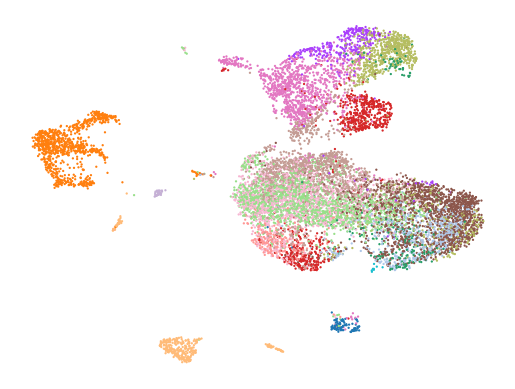

2025-03-06 14:31:14,306 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [20]:
logger.info("Consolidating low-frequency categories...")
# LABEL_KEY = BATCH_KEY
adata_cut = adata.copy()
# LABEL_KEY = "leiden_X_geneformer"
adata_cut = consolidate_low_frequency_categories(adata_cut, [LABEL_KEY], threshold=0)

# The color_key can be changed to anything in adata.obs, e.g. BATCH_KEY or LABEL_KEY.
color_key = LABEL_KEY

logger.info("Plotting UMAP...")
plot_umap(
    adata_cut,
    color_key=color_key,
    embedding_key="mmcontext_emb",
    title="",
    legend_loc=None,
    save_plot=False,
    save_format="svg",
    save_dir=".",
)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("umap_visualization.png", dpi=150)
    logger.info("UMAP plot saved to umap_visualization.png")

## 5. Pairwise Embedding Analysis

We use `create_emb_pair_dataframe` to create a paired DataFrame of two embeddings (omics vs text). Then:

- `visualize_embedding_clusters` to see how clusters form in a joint space.
- `plot_embedding_similarity` to examine similarity distributions for subsets.

2025-03-06 14:31:25,842 - root - INFO - Creating embedding pair dataframe...
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[label_key] = adata.obs[label_key][sampled_indices[idx]]
2025-03-06 14:31:25,855 - mmcontext.eval.utils - INFO - Created DataFrame with 400 rows (200 samples × 2 modalities)
2025-03-06 14:31:25,857 - root - INFO - Visualizing embedding clusters with UMAP...
2025-03-06 14:31:25,858 - mmcontext.pl.plotting - INFO - Applying UMAP to subset of size=20 with metric=cosine...
/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


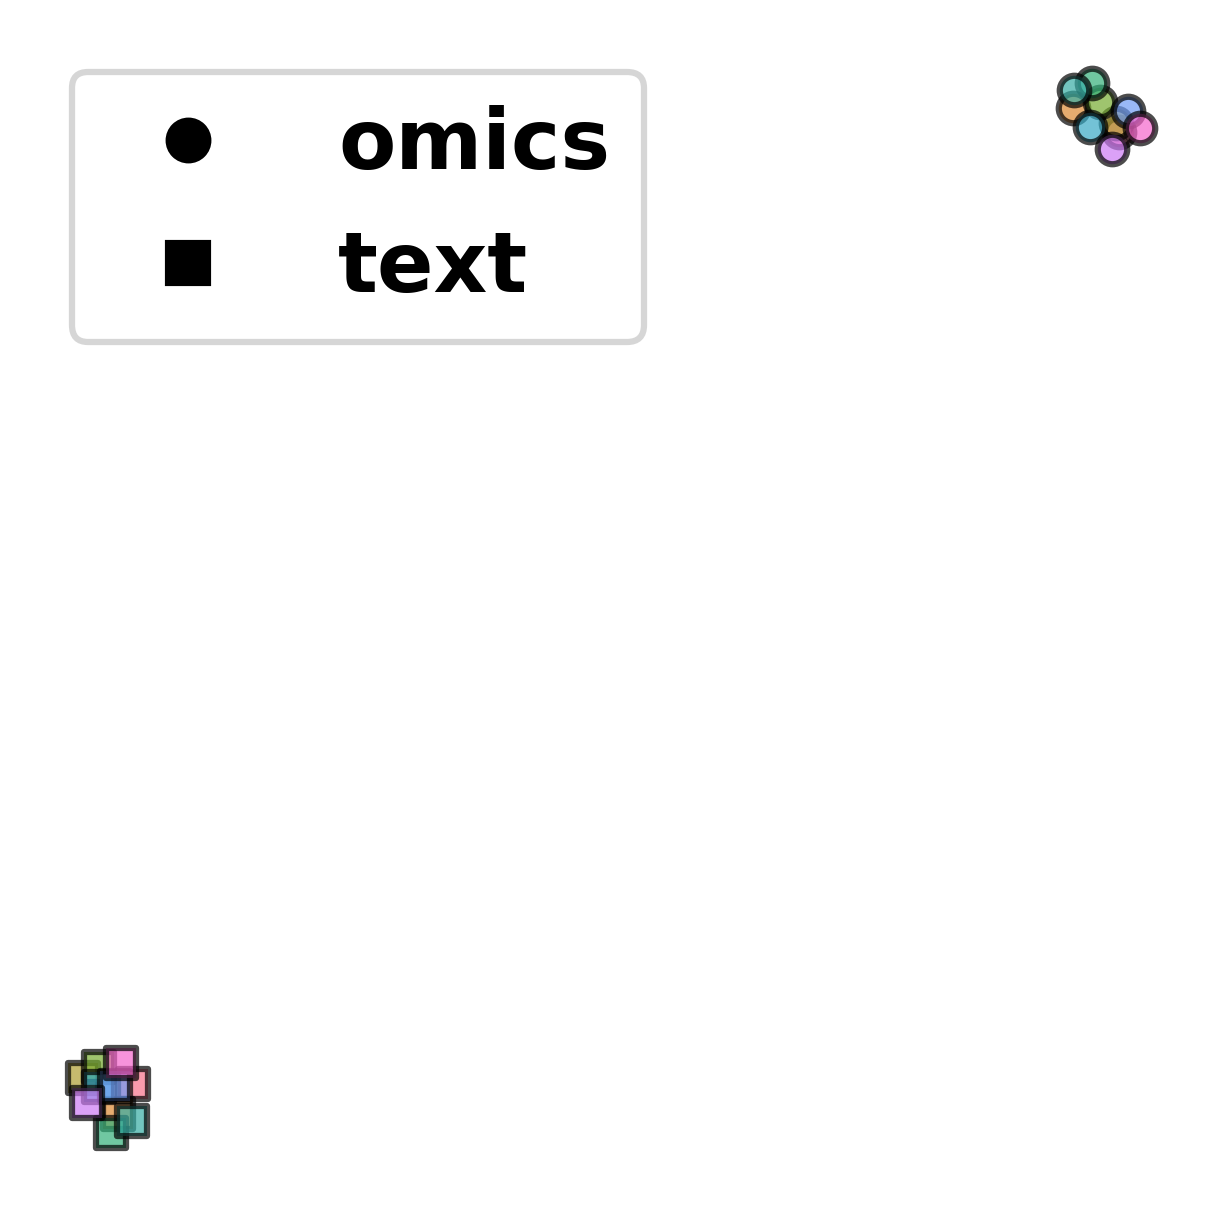

2025-03-06 14:31:26,796 - mmcontext.pl.plotting - INFO - Displayed embedding clusters interactively.


In [21]:
logger.info("Creating embedding pair dataframe...")
embedding_dict = {"omics": "mmcontext_emb", "text": "mmcontext_text_emb"}

emb_pair_df = create_emb_pair_dataframe(
    adata,
    embedding_dict,
    subset_size=200,
    label_keys=[BATCH_KEY, LABEL_KEY],
)

logger.info("Visualizing embedding clusters with UMAP...")
visualize_embedding_clusters(
    emb_pair_df,
    method="umap",
    metric="cosine",
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    n_samples=10,
    legend_fontsize=20,
    figsize=(5, 5),
    save_format="svg",
    save_plot=False,
    save_path="joint_embs_trained",
)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("emb_clusters.png", dpi=150)
    logger.info("Embedding clusters plot saved to emb_clusters.png")

In [22]:
from mmcontext.eval.embedding_alignment import evaluate_modality_alignment

modality_gap_irrelevant_score, full_comparison_score = evaluate_modality_alignment(emb_pair_df)

2025-03-06 14:31:30,633 - mmcontext.eval.embedding_alignment - INFO - Starting modality alignment evaluation.
2025-03-06 14:31:30,871 - mmcontext.eval.embedding_alignment - INFO - Modality-gap-irrelevant score: 0.568635
2025-03-06 14:31:30,872 - mmcontext.eval.embedding_alignment - INFO - Full-comparison score: 0.366150


2025-03-06 13:36:27,251 - root - INFO - Plot embedding similarity with subset=10...


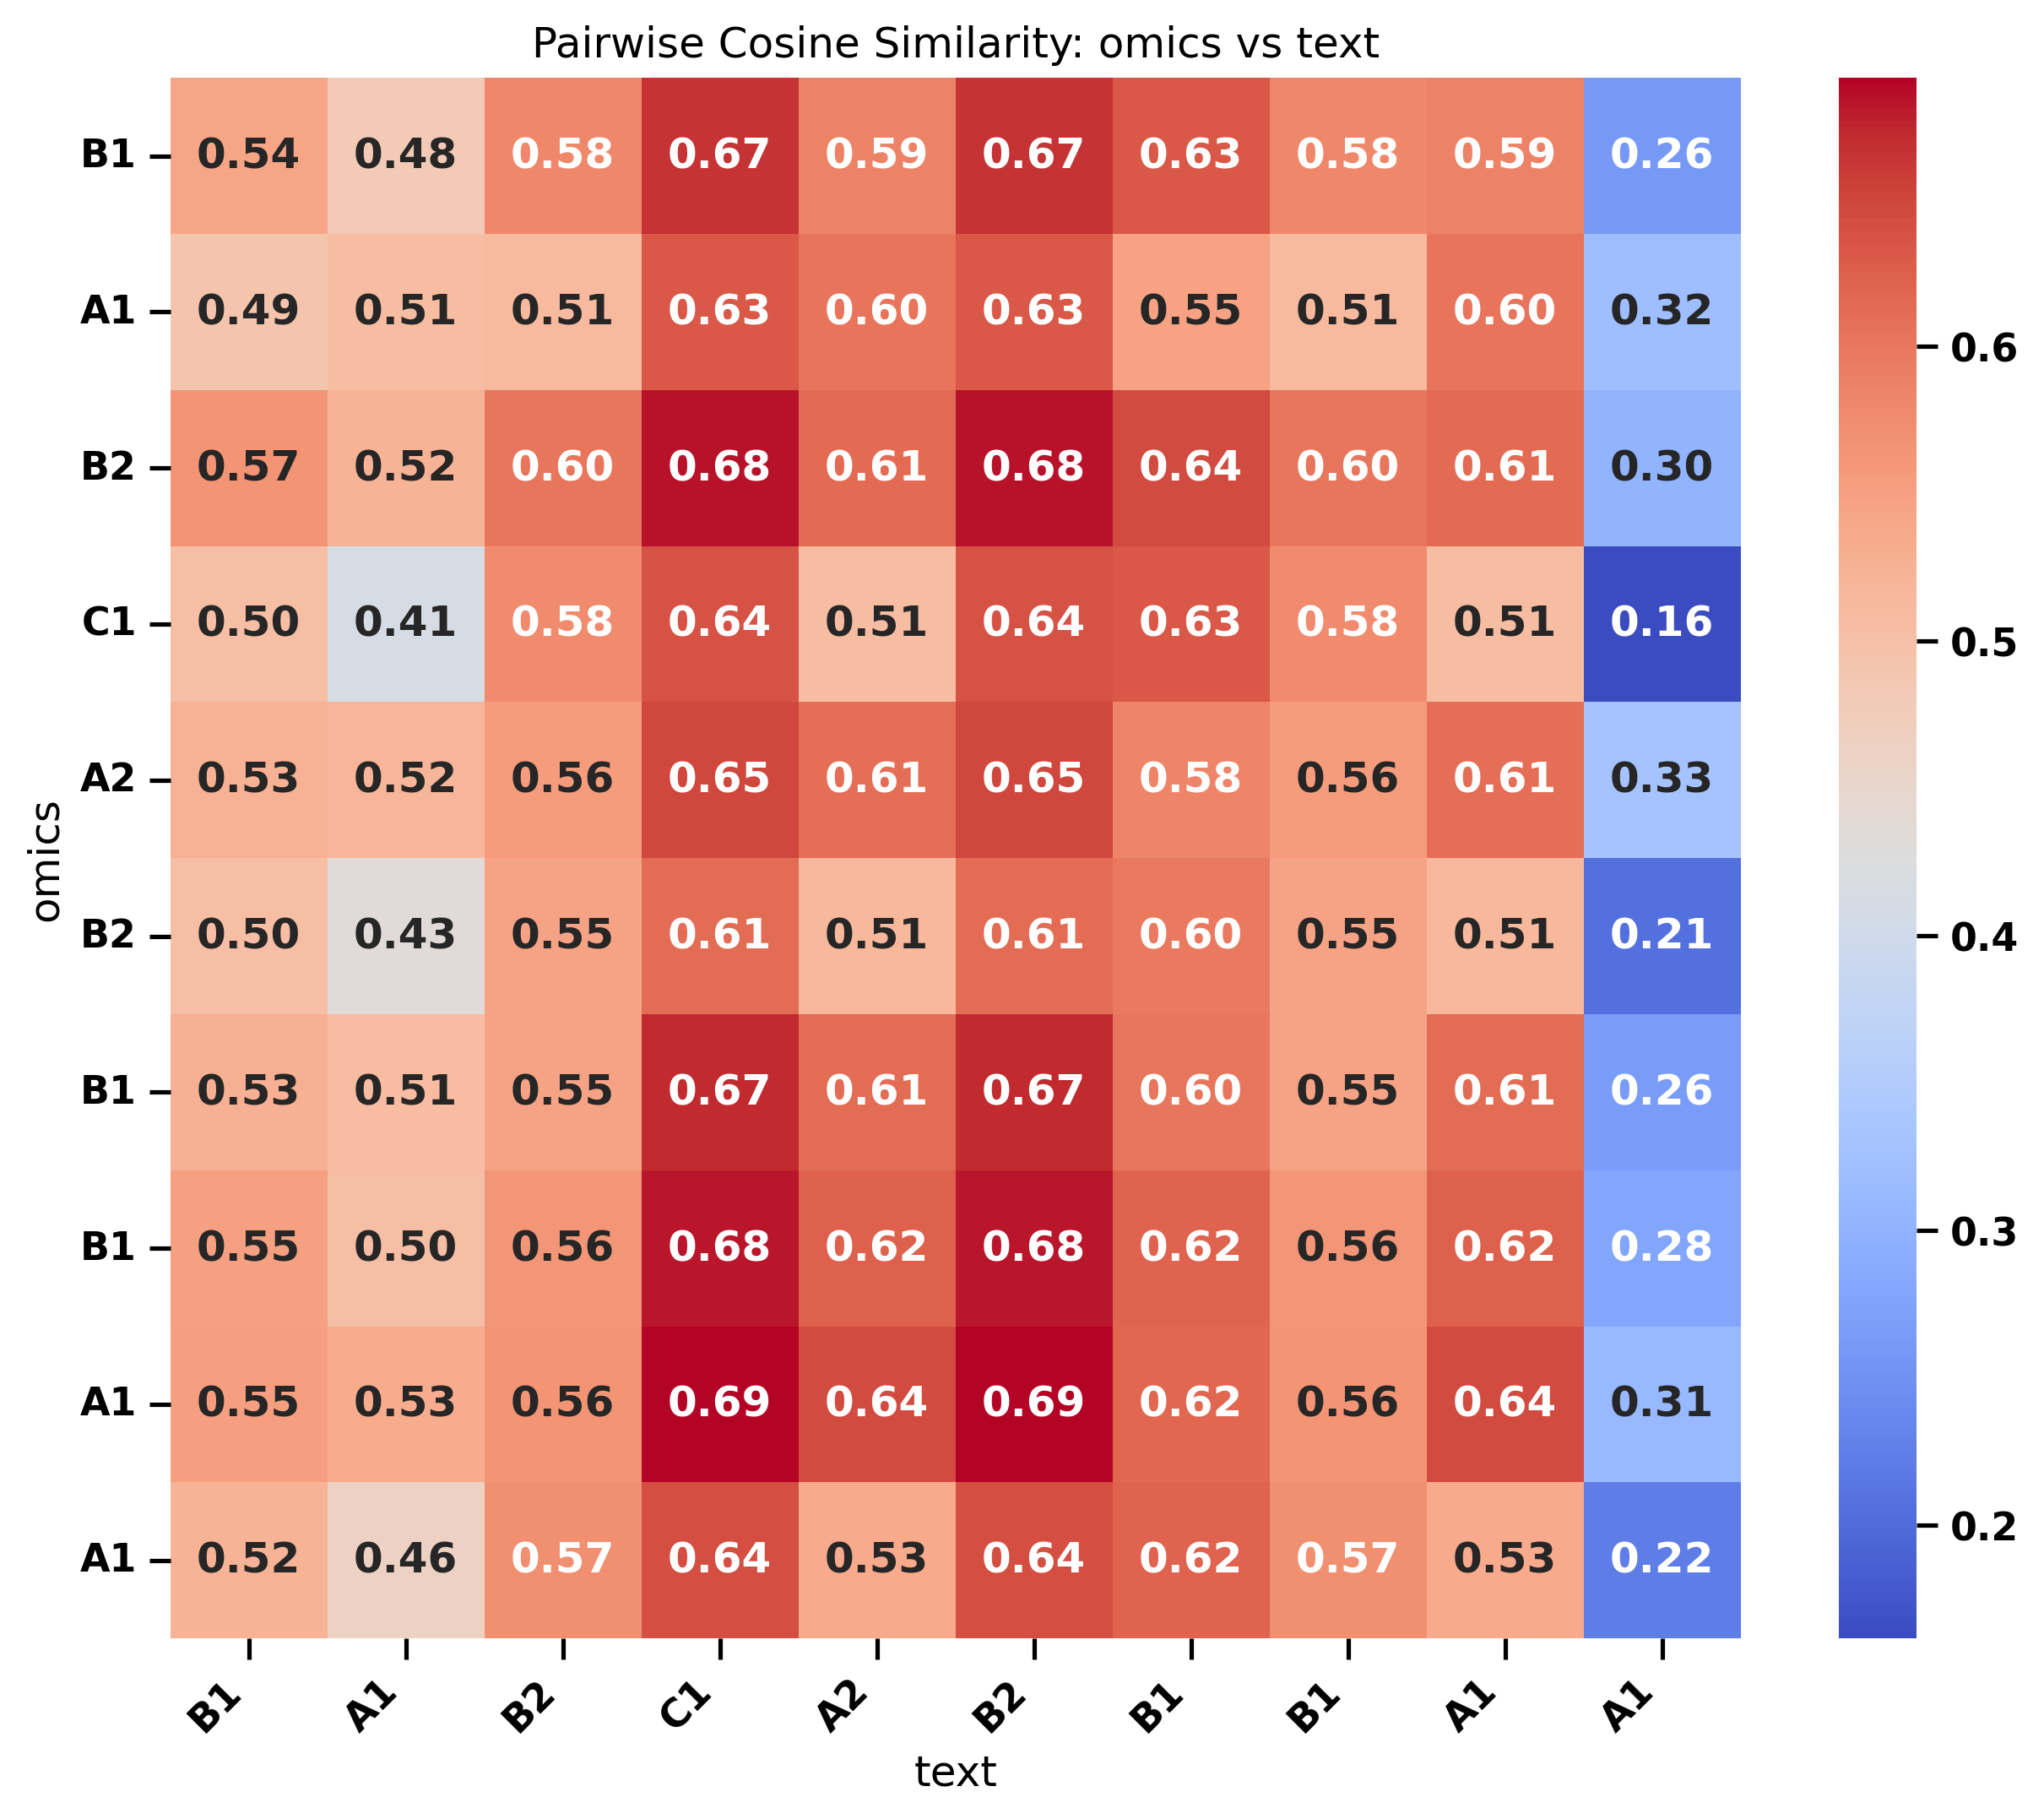

2025-03-06 13:36:27,387 - root - INFO - Plot embedding similarity with subset=10 using cell_type...


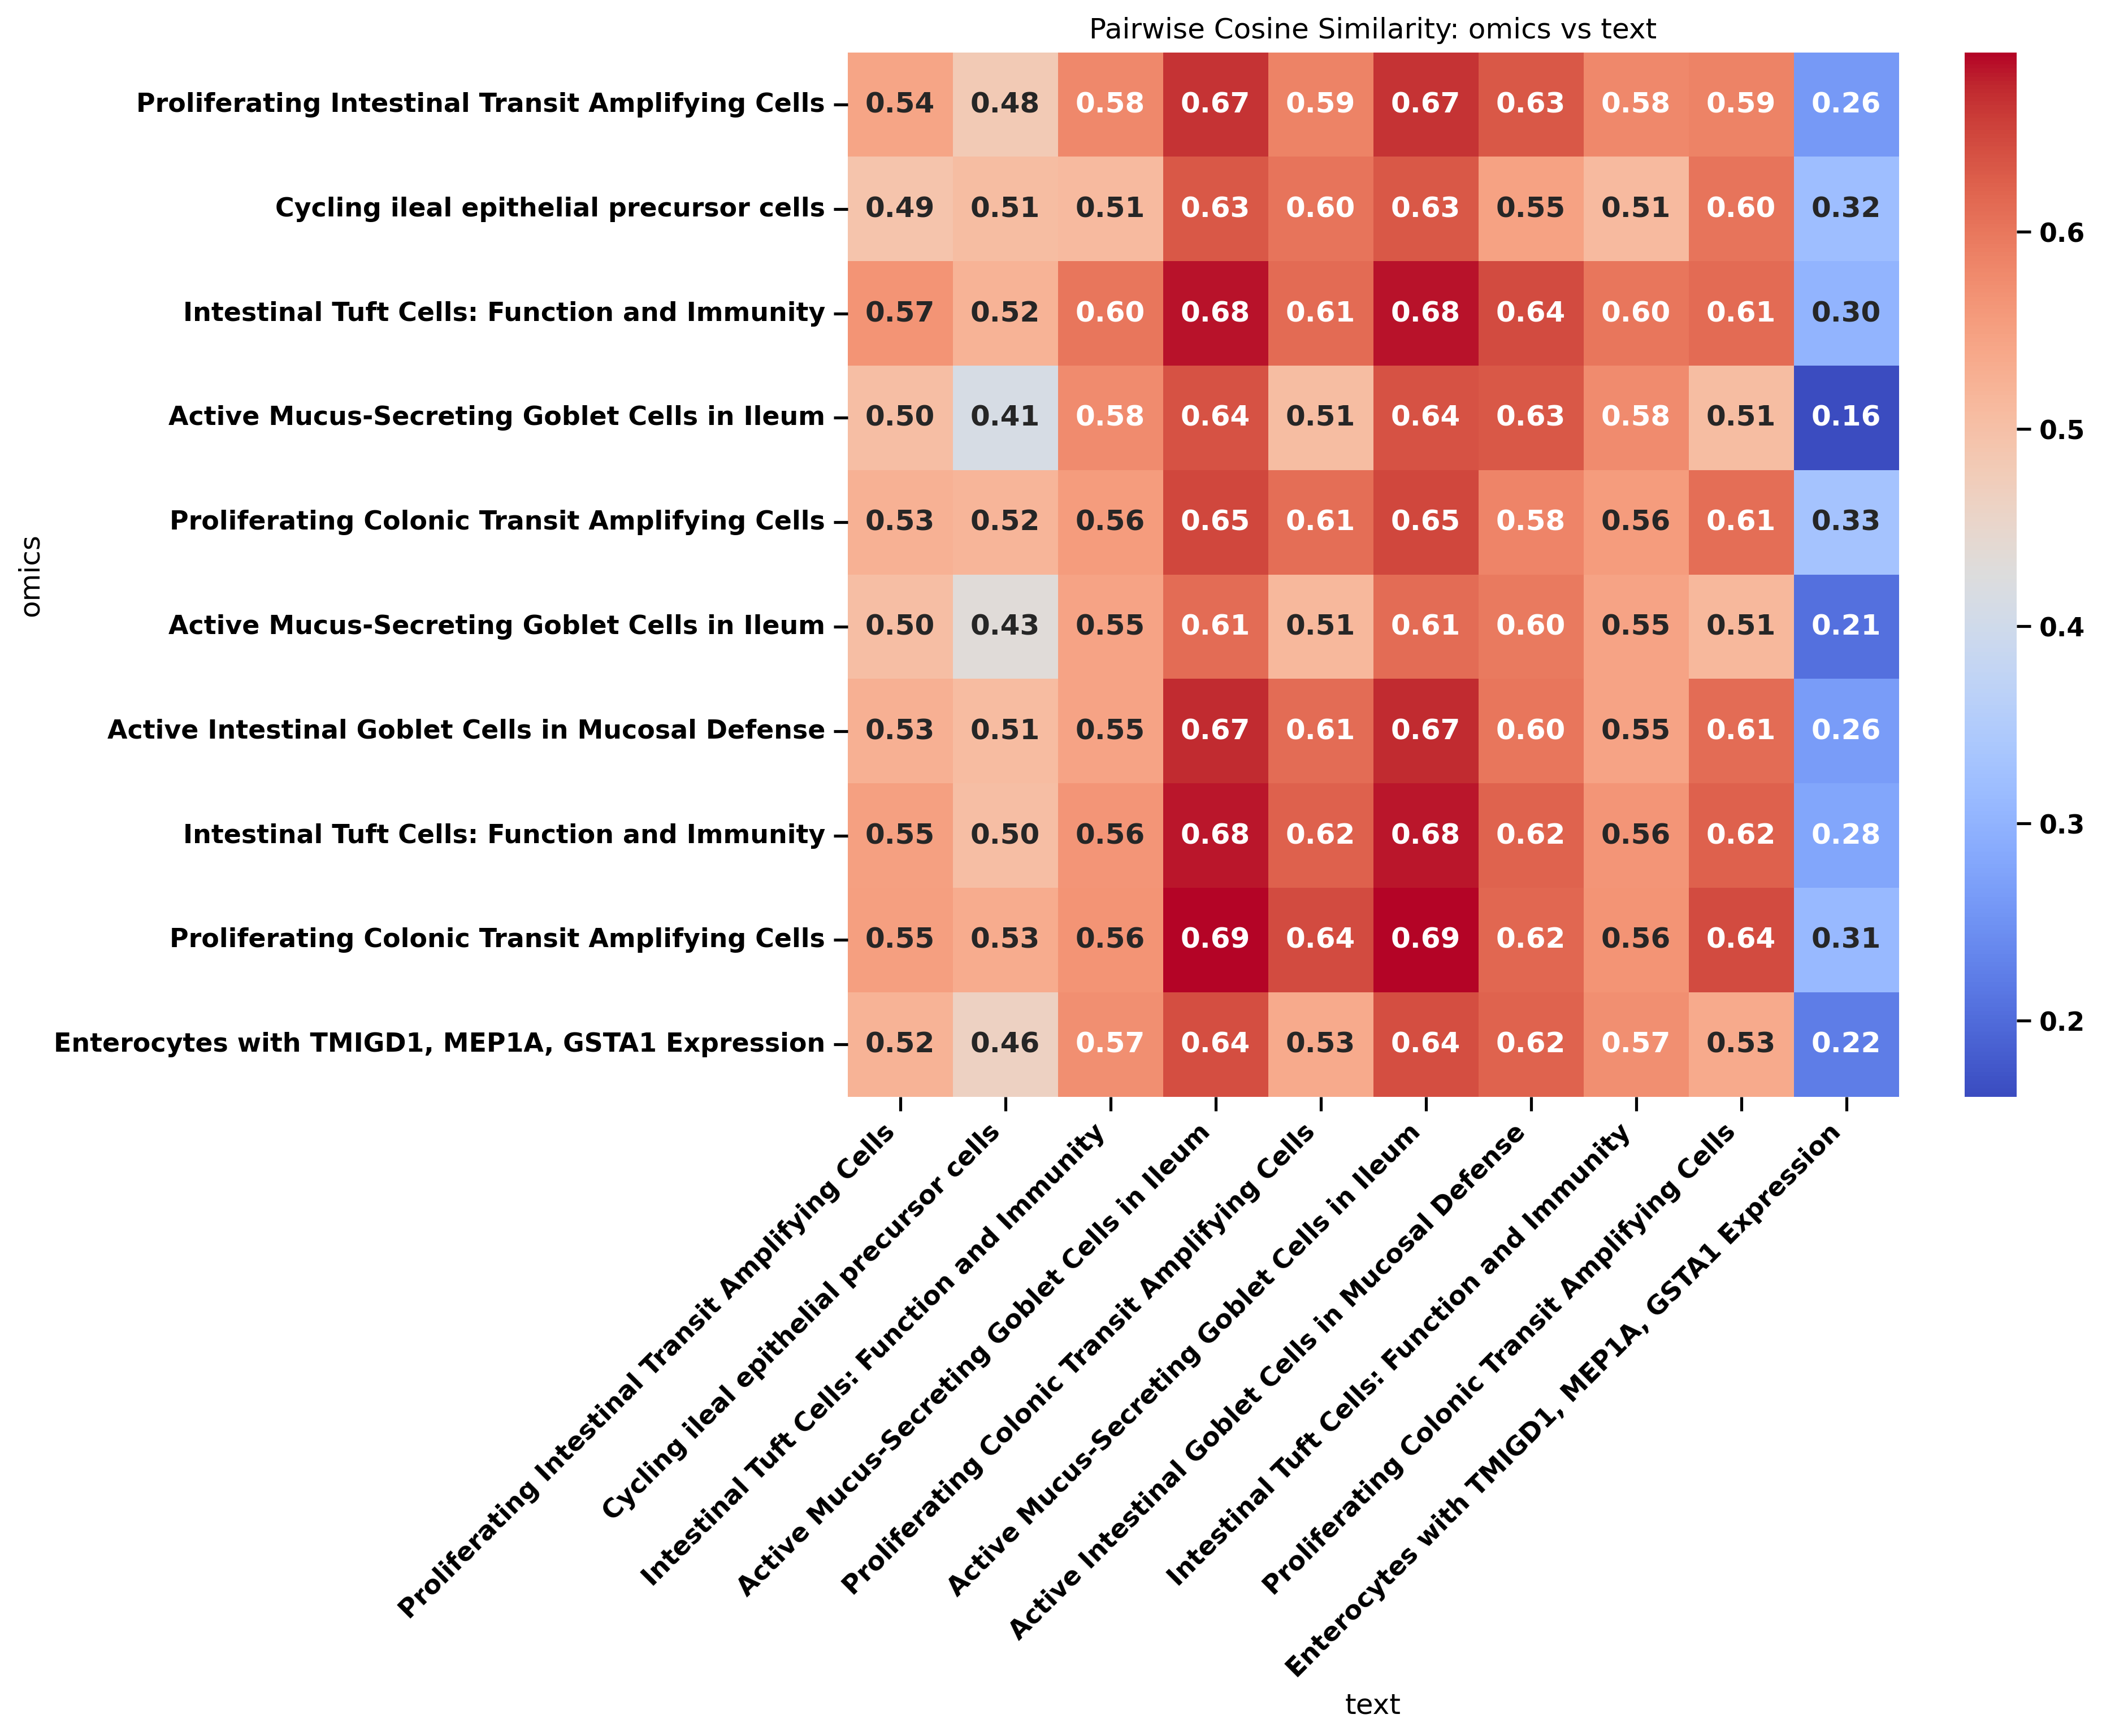

In [166]:
logger.info("Plot embedding similarity with subset=10...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=10, label_key=BATCH_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_batch.png", dpi=150)
    logger.info("Similarity plot (subset=10, batch) saved.")

logger.info("Plot embedding similarity with subset=10 using cell_type...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=10, label_key=LABEL_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_celltype.png", dpi=150)
    logger.info("Similarity plot (subset=10, cell_type) saved.")

If you want a larger subset for the similarity visualization (e.g., 200 samples):

2025-03-06 12:54:01,168 - root - INFO - Plot embedding similarity with subset=200...


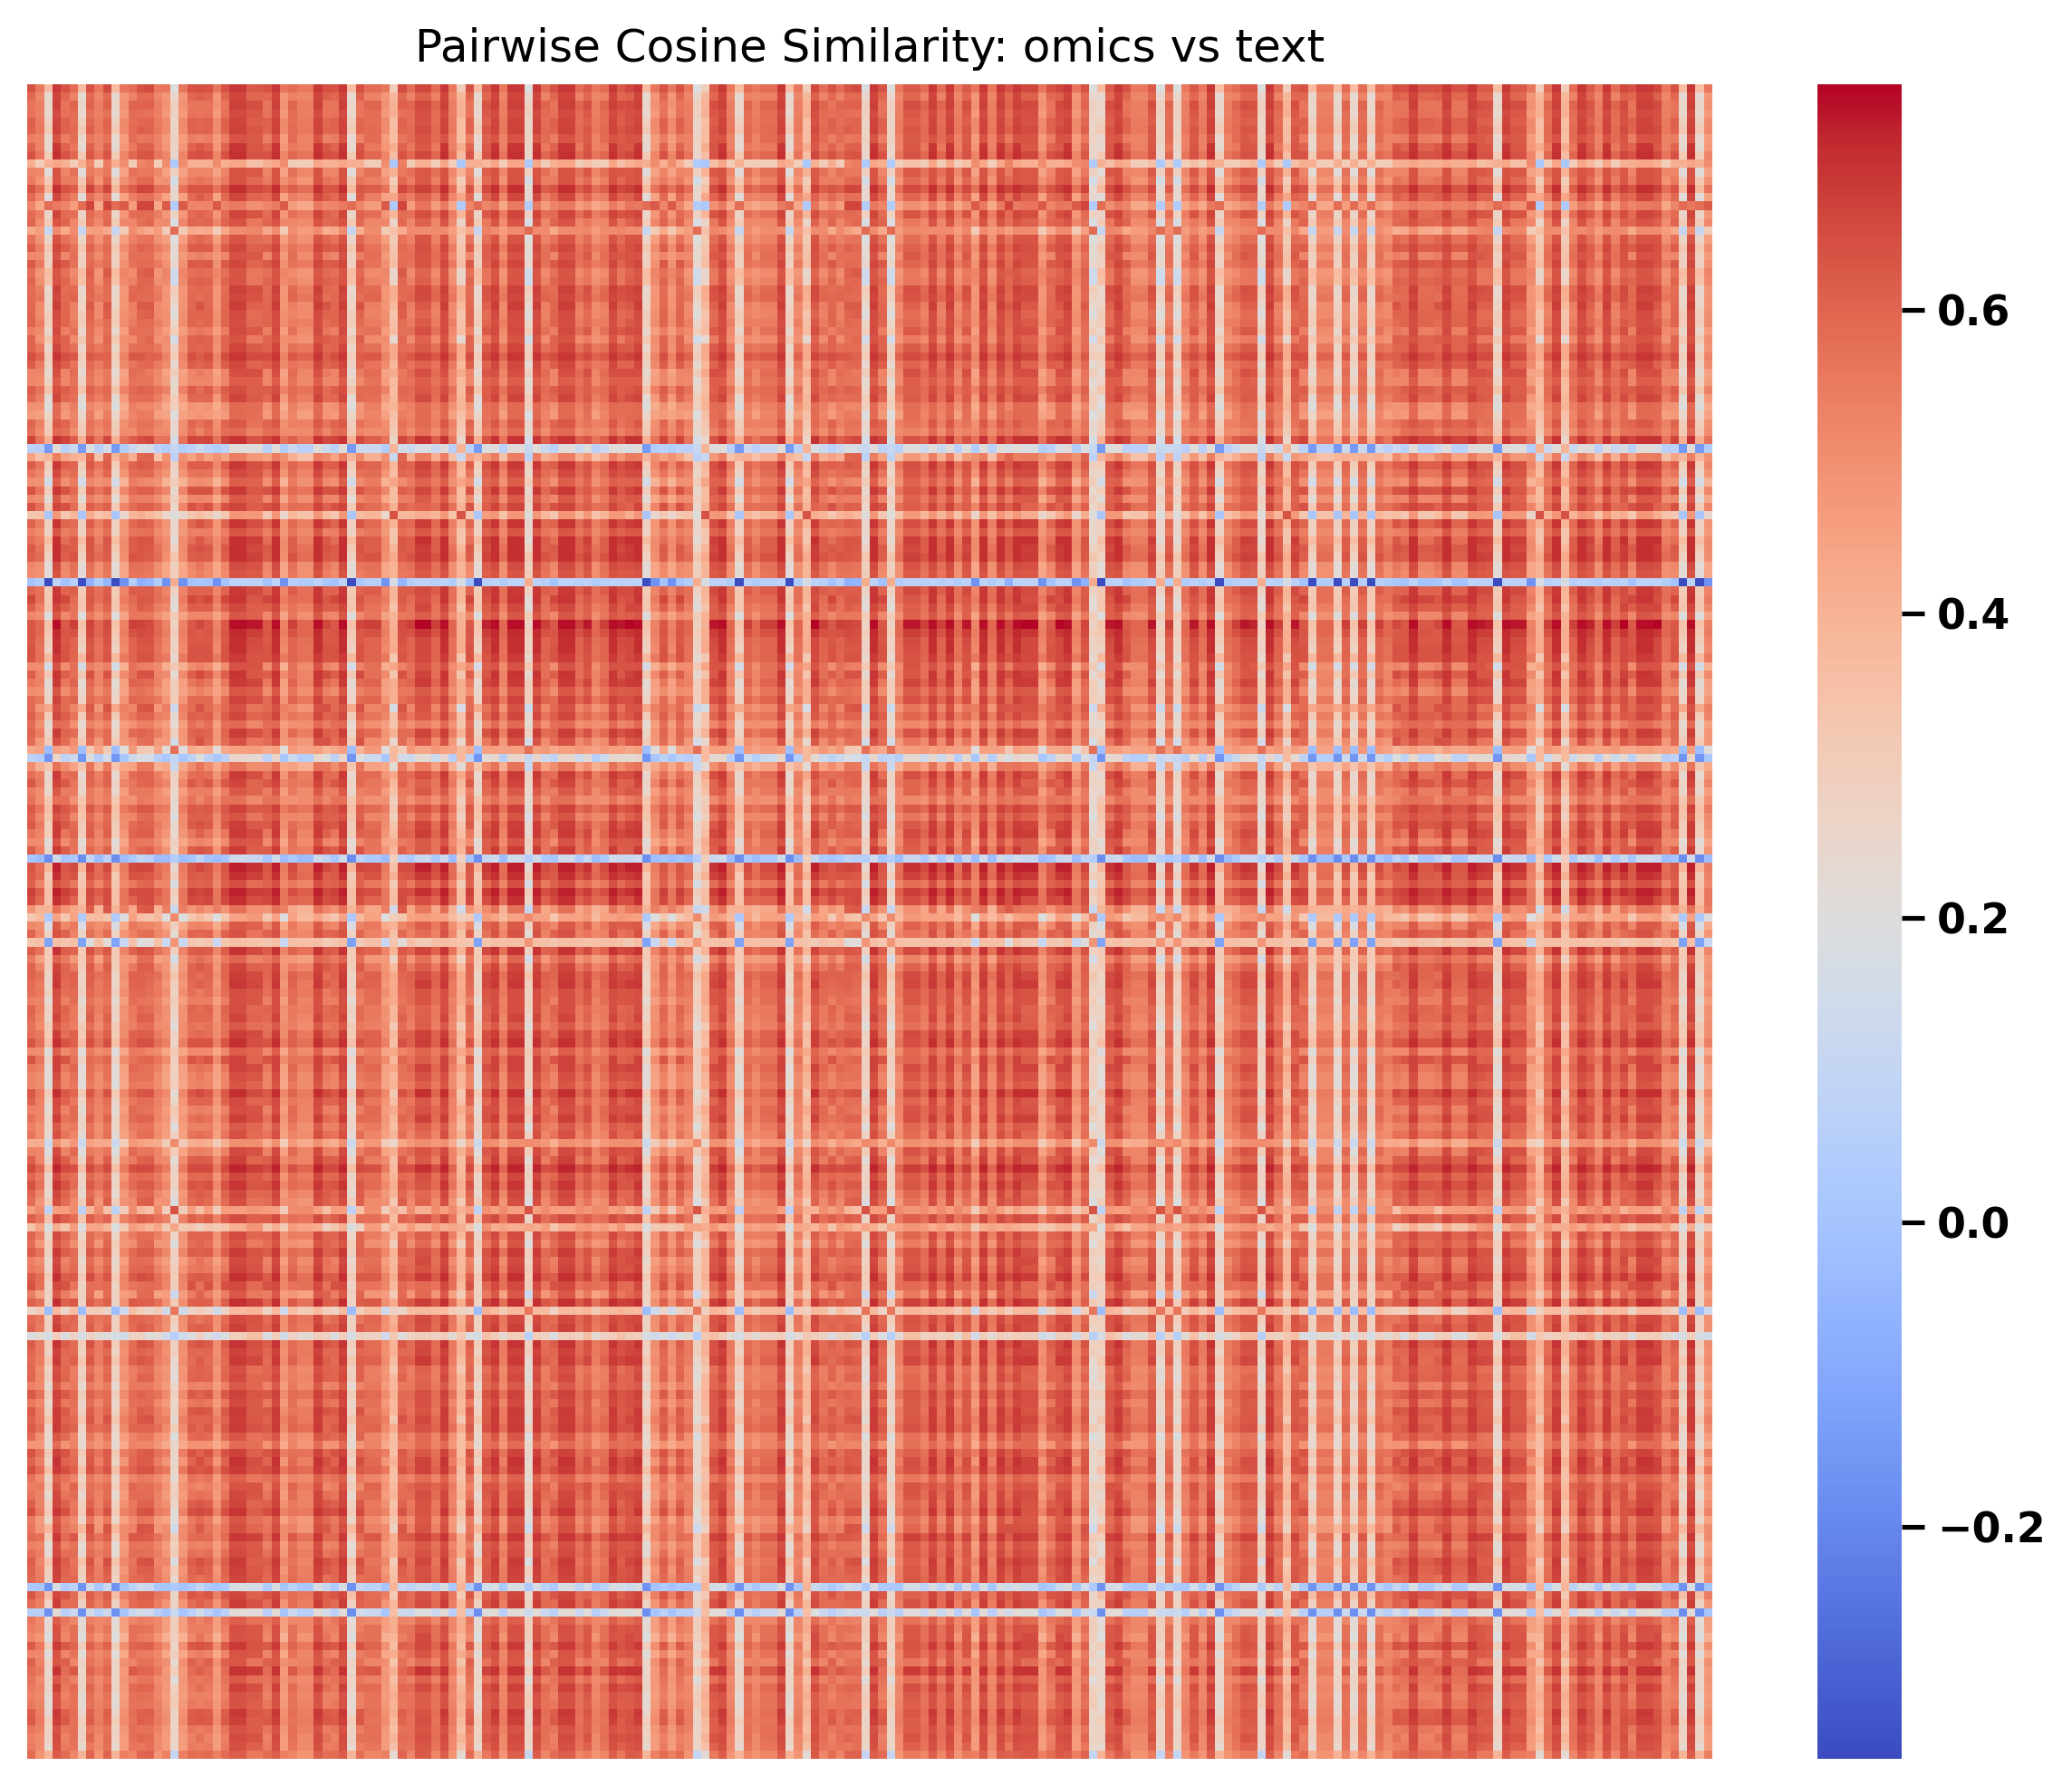

In [154]:
# Example: subset of 200
logger.info("Plot embedding similarity with subset=200...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=200, label_key=LABEL_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset200_celltype.png", dpi=150)
    logger.info("Similarity plot (subset=200, cell_type) saved.")

## 6. scibEvaluator

We can use scibEvaluator for evaluating batch integration and bio-conservation metrics (Luecken et al.).

In [167]:
EMBEDDING_KEYS.append("transcriptome_embeds")

In [17]:
# from mmcontext.pp.utils import remove_zero_variance_cells, remove_zero_variance_genes
# adata = remove_zero_variance_genes(adata)
# adata = remove_zero_variance_cells(adata)

In [1]:
logger.info("Initializing scibEvaluator...")
evaluator = scibEvaluator(
    adata=adata,
    batch_key=BATCH_KEY,
    label_key=LABEL_KEY,
    embedding_key=EMBEDDING_KEYS,
    n_top_genes=5000,
    max_cells=5000,
    in_parallel=False,
)

logger.info("Running scibEvaluator...")
res = evaluator.evaluate()
res_df = pd.DataFrame(res)
res_df

NameError: name 'logger' is not defined

2025-03-06 13:40:25,251 - mmcontext.pl.plotting - INFO - Generating grouped bar chart with metrics on x-axis and type categories as color groups.


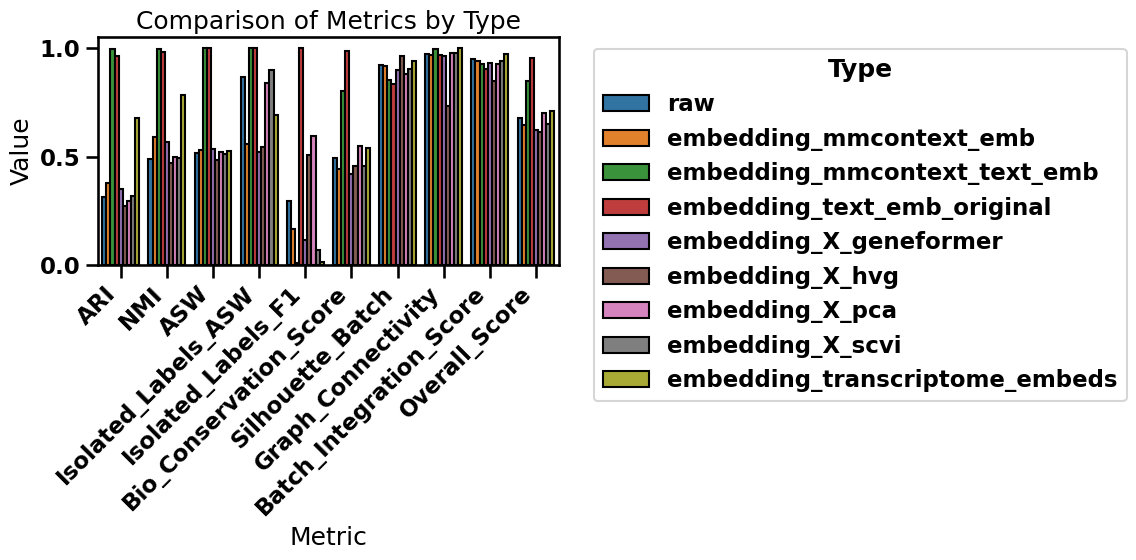

2025-03-06 13:40:25,424 - mmcontext.pl.plotting - INFO - Displayed grouped bar chart interactively.


In [169]:
plot_grouped_bar_chart(res_df)

## 7. Annotation and Query

We can annotate and query our omics data using `OmicsQueryAnnotator`.

2025-03-06 14:31:46,818 - root - INFO - Annotating omics data...
2025-03-06 14:31:46,831 - mmcontext.engine.query_annotate - INFO - Using matrix multiplication to compute label similarities.
Batches: 100%|██████████| 350/350 [00:05<00:00, 61.93it/s]
2025-03-06 14:31:52,523 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-03-06 14:31:52,523 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-03-06 14:31:52,532 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-03-06 14:31:58,472 - root - INFO - Plotting annotated data...
2025-03-06 14:31:58,473 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-03-06 14:31:58,473 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.
... storing 'best_label' as categorical


<Figure size 800x800 with 0 Axes>

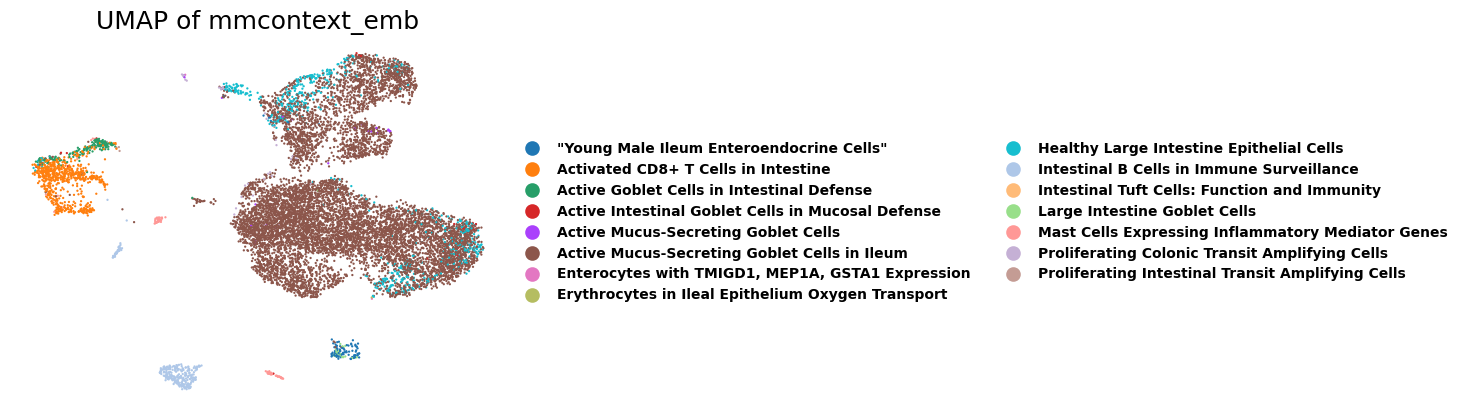

2025-03-06 14:32:03,745 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-03-06 14:32:03,745 - root - INFO - Evaluating annotation accuracy...
2025-03-06 14:32:03,746 - mmcontext.eval.annotation_accuracy - INFO - Evaluating annotation accuracy for keys 'cluster_label' and 'best_label'. Accuracy = 21.83%
2025-03-06 14:32:03,746 - root - INFO - Accuracy of annotation: 0.21834451901565996


In [23]:
logger.info("Annotating omics data...")
annotator = OmicsQueryAnnotator(model)

# Suppose we have some labels to annotate, e.g. from an external source
labels = adata.obs[LABEL_KEY].values.tolist()
annotator.annotate_omics_data(adata, labels, text_template="{}")

logger.info("Plotting annotated data...")
plot_umap(adata, color_key="best_label", embedding_key="mmcontext_emb")

logger.info("Evaluating annotation accuracy...")
score = evaluate_annotation_accuracy(
    adata,
    true_key=LABEL_KEY,  # or whichever key is ground truth for your scenario
    inferred_key="best_label",
)
logger.info(f"Accuracy of annotation: {score}")

### Example: Query with text
You can query the dataset with text prompts and then visualize the result.

2025-03-10 15:12:36,563 - root - INFO - Annotating omics data...
2025-03-10 15:12:36,563 - mmcontext.engine.query_annotate - INFO - Encoding the queries.
Batches: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
2025-03-10 15:12:36,735 - mmcontext.engine.query_annotate - INFO - Computing similarity between queries and omics data.
2025-03-10 15:12:37,140 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-03-10 15:12:37,141 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

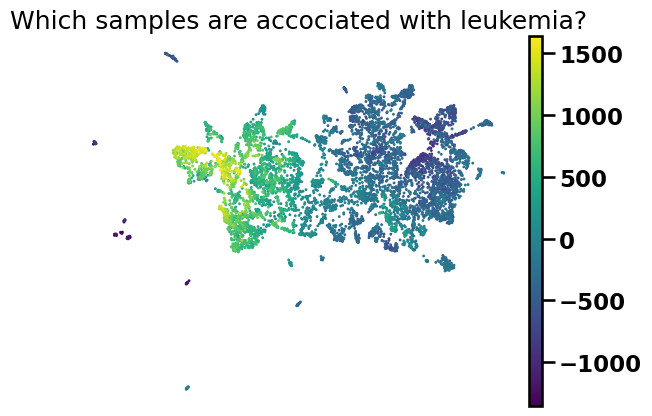

2025-03-10 15:12:43,119 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [54]:
# Example usage
logger.info("Annotating omics data...")
annotator = OmicsQueryAnnotator(model, is_cosine=False)
qa = annotator  # if the OmicsQueryAnnotator has a method query_with_text
# logger.info("Querying dataset for 'This is a immune cell'...")
query = "Which samples are accociated with leukemia?"
qa.query_with_text(adata, [query])

# Visualize
plot_query_scores_umap(adata, embedding_key="mmcontext_emb")
if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("query_scores_umap.png", dpi=150)
    logger.info("Query scores UMAP saved.")

In [42]:
ensemble_id = "ENSG00000107758"
if ensemble_id in adata.var["ensembl_id"]:
    adata.obs[f"{ensemble_id}_expression"] = adata.X[:, adata.var["ensembl_id"] == ensemble_id]
else:
    logger.info(f"{ensemble_id} not found in adata.var['ensembl_id']")

In [46]:
gene_name = "IL6"
if gene_name in adata.var["gene_name"]:
    adata.obs[f"{gene_name}_expression"] = adata.X[:, adata.var["gene_name"] == gene_name]
else:
    logger.info(f"Gene {gene_name} not found in dataset.")

In [48]:
logger.info("Consolidating low-frequency categories...")
# The color_key can be changed to anything in adata.obs, e.g. BATCH_KEY or LABEL_KEY.
color_key = f"{gene_name}_expression"

logger.info("Plotting UMAP...")
plot_umap(
    adata,
    color_key=color_key,
    embedding_key="mmcontext_emb",
    title="",
    legend_loc=None,
    save_plot=False,
    save_format="svg",
    save_dir=".",
)

2025-03-10 14:56:00,562 - root - INFO - Consolidating low-frequency categories...
2025-03-10 14:56:00,563 - root - INFO - Plotting UMAP...
2025-03-10 14:56:00,563 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-03-10 14:56:00,564 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


KeyboardInterrupt: 

In [55]:
from mmcontext.eval.utils import subset_adata_by_query_score

top_adata, bottom_adata = subset_adata_by_query_score(
    adata=adata,
    query_key=query,
    percentile=10.0,  # e.g., top 10% vs bottom 10%
)

print("Top subset shape:", top_adata.shape)
print("Bottom subset shape:", bottom_adata.shape)

2025-03-10 15:12:43,227 - mmcontext.eval.utils - INFO - Splitting data by 'Which samples are accociated with leukemia?' scores at the 10.0th/(90.0th) percentile. Found 700 cells in bottom subset, 700 cells in top subset.


Top subset shape: (700, 67125)
Bottom subset shape: (700, 67125)


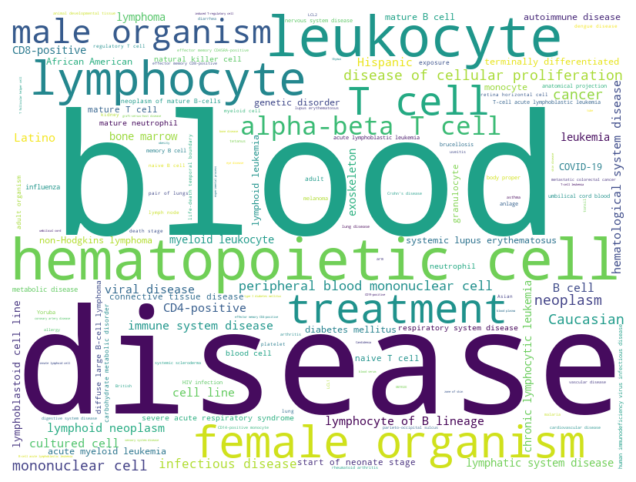

In [56]:
from mmcontext.pl.plotting import plot_wordcloud

plot_wordcloud(top_adata.obs["mapped_ontology_terms"])

Investigate Enrichment of Genes for respondant cells

## 8. Zero-Shot Classification ROC

Below is a function to compute a ROC-AUC for cell-type prediction (or any label) in a zero-shot manner.

In [27]:
logger.info("Computing zero-shot classification ROC...")
macro_auc, auc_details = zero_shot_classification_roc(
    adata,
    model,
    label_key=ZERO_SHOT_LABEL_KEY,
    emb_key=ZERO_SHOT_EMB_KEY,
    text_template="{}",
    device="cpu",
)
logger.info(f"Macro AUC: {macro_auc}")
logger.info(f"Detail per label: {auc_details}")

2025-03-04 16:03:13,647 - root - INFO - Computing zero-shot classification ROC...
2025-03-04 16:03:13,649 - mmcontext.eval.classification_roc - INFO - Building text queries for each label...
2025-03-04 16:03:13,650 - mmcontext.eval.classification_roc - INFO - Embedding 16 label queries...
Batches: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]
2025-03-04 16:03:13,732 - mmcontext.eval.classification_roc - INFO - Retrieving sample embeddings from adata.obsm[mmcontext_emb]...
2025-03-04 16:03:13,733 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-03-04 16:03:13,733 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-03-04 16:03:13,736 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-03-04 16:03:13,770 - mmcontext.eval.classification_roc - INFO - Zero-shot cell-type prediction macro-AUC: 0.7000
2025-03-04 16:03:13,770 - root - INFO - Macro AUC: 0.6999906753071574
2025-03-04 16:03:13,771 - root - INFO - Deta

## 9. (Optional) Saving Notebook Outputs

If you wish to programmatically save this notebook (e.g., for batch runs or CI/CD), you can use a dedicated library like `nbformat` or `papermill`. Here's a small snippet as an example (commented out by default).

In [ ]:
# Uncomment and adapt if you want to save the executed notebook programmatically
# import nbformat
# from nbformat.v4 import new_notebook
# from nbconvert.preprocessors import ExecutePreprocessor
# from nbconvert import HTMLExporter
#
# if SAVE_RESULTS:
#     logger.info("Saving notebook...")
#     with open("evaluation_notebook.ipynb", "r") as f:
#         nb = nbformat.read(f, as_version=4)
#     ep = ExecutePreprocessor(timeout=600)
#     ep.preprocess(nb, {'metadata': {'path': './'}})
#     with open("evaluation_notebook_executed.ipynb", "w") as f:
#         nbformat.write(nb, f)
#
#     # Optionally export to HTML
#     html_exporter = HTMLExporter()
#     body, _ = html_exporter.from_notebook_node(nb)
#     with open("evaluation_notebook_executed.html", "w") as f:
#         f.write(body)
#
#     logger.info("Notebook saved as evaluation_notebook_executed.ipynb and HTML version.")
